# Linear Regression 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [1]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [3]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [4]:
df = fdr.DataReader('036570','2020-01-01', '2022-04-12') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [5]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

In [6]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246.]),
 <a list of 10 Text major ticklabel objects>)

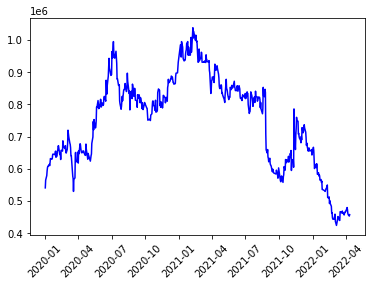

In [7]:
plt.plot(df['Close'], 'b-')
plt.xticks(rotation=45)  # X축 눈금을 회전

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [8]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-04-12\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"리니지\",\"keywords\":[\"리니지\",\"Lineage\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"m\"}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [9]:
search_count_json = json.loads(search_count)

In [10]:
df_json = pd.DataFrame(search_count_json["results"][0]["data"])

In [11]:
df_json

,period,ratio
0,2020-01-01,35.08771
1,2020-01-02,35.08771
2,2020-01-03,17.54385
3,2020-01-04,26.31578
4,2020-01-05,14.03508
...,...,...
826,2022-04-08,7.01754
827,2022-04-09,14.03508
828,2022-04-10,10.52631
829,2022-04-11,8.77192


## 1-3. 데이터 전처리 및 Merge하기

In [12]:
df_json.columns = ['Date', 'Count']

In [13]:
df_json['Date'] = pd.to_datetime(df_json['Date'])

In [14]:
df_json

,Date,Count
0,2020-01-01,35.08771
1,2020-01-02,35.08771
2,2020-01-03,17.54385
3,2020-01-04,26.31578
4,2020-01-05,14.03508
...,...,...
826,2022-04-08,7.01754
827,2022-04-09,14.03508
828,2022-04-10,10.52631
829,2022-04-11,8.77192


In [15]:
df_json.reset_index(drop=True)
df_json.set_index("Date")

,Count
Date,
2020-01-01,35.08771
2020-01-02,35.08771
2020-01-03,17.54385
2020-01-04,26.31578
2020-01-05,14.03508
...,...
2022-04-08,7.01754
2022-04-09,14.03508
2022-04-10,10.52631


In [16]:
#Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html#merging-asof
df_all = pd.merge_asof(df, df_json, on="Date", by="Date")  # 시계열 데이터프레임을 합치는 함수

In [17]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Count
0,2020-01-02,542000,545000,539000,541000,40246,0.000000,35.08771
1,2020-01-03,547000,568000,542000,565000,112404,0.044362,17.54385
2,2020-01-06,562000,587000,562000,579000,107006,0.024779,21.05263
3,2020-01-07,583000,596000,574000,594000,84378,0.025907,7.01754
4,2020-01-08,587000,604000,584000,604000,109267,0.016835,36.84210
...,...,...,...,...,...,...,...,...
558,2022-04-06,475000,483500,469000,474000,96750,-0.012500,3.50877
559,2022-04-07,469000,471500,462000,462000,103079,-0.025316,5.26315
560,2022-04-08,462500,466500,453500,458000,87055,-0.008658,7.01754
561,2022-04-11,450500,459000,449000,453500,59322,-0.009825,8.77192


In [18]:
## You need to visualized a relational graph
plt.figure(figsize=(20,10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [19]:
df_all.any().isnull()  # any: 하나라도 있는지?, all: 전부

Date      False
Open      False
High      False
Low       False
Close     False
Volume    False
Change    False
Count     False
dtype: bool

In [20]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)  # np.min(data, axis)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train

# 2. Define Model

In [21]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear_classifier = torch.nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x):
        print("inX:" ,x)
        print("inSquee",x.unsqueeze(0))
        x = self.linear_classifier(x.unsqueeze(0))
        print("outX:" ,x)
        return x

# 3. Define the loss function and the optimizer

In [22]:
input_dim = 1
output_dim = 1
learning_rate = 0.01
model = LinearModel(input_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [23]:
def train(train_x, train_y, loss_function, optimizer, model):

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    print(idx)
    print(train_x[idx])
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    print("the value of logit", logit)
    loss = loss_function(logit, train_y_tensor)
    print("the value of loss", loss)

    loss.backward()
    optimizer.step()

  return ""

# 5. Training 

In [24]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_all["Count"].to_numpy(),df_all["Change"].to_numpy(), test_size=0.2)

In [25]:
best_model = None
best_model = train(train_x, train_y, loss_function, optimizer, model)

0
14.03508
inX: tensor(14.0351)
inSquee tensor([14.0351])
outX: tensor([0.4314], grad_fn=<AddBackward0>)
the value of logit tensor([0.4314], grad_fn=<AddBackward0>)
the value of loss tensor(0.2305, grad_fn=<MseLossBackward0>)
1
36.8421
inX: tensor(36.8421)
inSquee tensor([36.8421])
outX: tensor([-4.7137], grad_fn=<AddBackward0>)
the value of logit tensor([-4.7137], grad_fn=<AddBackward0>)
the value of loss tensor(22.4705, grad_fn=<MseLossBackward0>)
2
28.07017
inX: tensor(28.0702)
inSquee tensor([28.0702])
outX: tensor([94.6739], grad_fn=<AddBackward0>)
the value of logit tensor([94.6739], grad_fn=<AddBackward0>)
the value of loss tensor(8958.3008, grad_fn=<MseLossBackward0>)
3
17.54385
inX: tensor(17.5438)
inSquee tensor([17.5438])
outX: tensor([-874.6965], grad_fn=<AddBackward0>)
the value of logit tensor([-874.6965], grad_fn=<AddBackward0>)
the value of loss tensor(765171.6250, grad_fn=<MseLossBackward0>)
4
7.01754
inX: tensor(7.0175)
inSquee tensor([7.0175])
outX: tensor([1820.7222

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([24.5614])
outX: tensor([-3360225.2500], grad_fn=<AddBackward0>)
the value of logit tensor([-3360225.2500], grad_fn=<AddBackward0>)
the value of loss tensor(1.1291e+13, grad_fn=<MseLossBackward0>)
17
22.80701
inX: tensor(22.8070)
inSquee tensor([22.8070])
outX: tensor([34594556.], grad_fn=<AddBackward0>)
the value of logit tensor([34594556.], grad_fn=<AddBackward0>)
the value of loss tensor(1.1968e+15, grad_fn=<MseLossBackward0>)
18
22.80701
inX: tensor(22.8070)
inSquee tensor([22.8070])
outX: tensor([-3.2599e+08], grad_fn=<AddBackward0>)
the value of logit tensor([-3.2599e+08], grad_fn=<AddBackward0>)
the value of loss tensor(1.0627e+17, grad_fn=<MseLossBackward0>)
19
40.35087
inX: tensor(40.3509)
inSquee tensor([40.3509])
outX: tensor([5.4303e+09], grad_fn=<AddBackward0>)
the value of logit tensor([5.4303e+09], grad_fn=<AddBackward0>)
the value of loss tensor(2.9488e+19, grad_fn=<MseLossBackward0>)
20
5.26315
inX: tensor(5.2632)
inSquee tensor([5.2632])
outX: tensor([-2.2460e+

In [26]:
#len(train_y)
len(train_x)

450